## Notes (REMOVE)
discuss how this exampled could relate to people interested in providing other foaia data


# 2015 NYC ICE Detention Data
**Data Source:** [Total Individuals Detained by ICE FY15 through August 2015 (Part 1-5)](https://www.ice.gov/foia/library) <br>
**Download the Output:** NA


## Overview 

This notebook provides functionality to download, process and explore ICE detention data on persons initially detained in the NYC metro area. The methods and analysis could be applied to other similar ICE detention datasets if they become available. 


## Technical Approach

There are many files on the ICE FOIA Library we will specifically look at the files marked `Total Individuals Detained by ICE FY15 through August 2015 (Part 1) - (Part 5)`. A link to one of these files is [here](https://www.ice.gov/doclib/foia/dfs/detained-FY15-Aug-i.xlsx). The specific url for one of these files is `https://www.ice.gov/doclib/foia/dfs/detained-FY15-Aug-i.xlsx`.  

We use Python to download and aggregate the 5 different `.xlsx` workbooks. Then use python libraries to process that data to select only those persons initial detained in the NYC area, and show visualizations and analysis on this dataset. 

## Skills Learned
* How to download files using python
* How to aggregate large xlsx files into a single dataframe
* Explore and visualize ICE detention data. 

## Background Info 

Notes from the XLSX file: Information on the specifics for each ICE detention		

**Key items**
*  A Unique Subject ID has been provided as a sequence number or other designation to identify records relating to the same alien subject, as well as linking the subjects detention details to additional charge details (75).	
* Order of Detentions has been provided to show the ordering of facility or facilities for the present detention period (66).	
* For “detention location code for book-in facility” please refer to History Detention Facility Code and History Detention Facility.  Please also refer to the History Detention Facility and Code for History Release Reasons showing transfer for “if release type is a transfer, detention location code for receiving facility” (65, 72).	

**Additional**
* For the “date of the very first detention book-in in the entire detention history for that alien” please refer to the Original Book In Date and Time (59).															
* For both the “date of the initial book-in” and “time of day for initial book-in” refer to Initial Book In Date and Time (60, 61)															
* For both the “date of book-in to this facility” and “time of day for book-in to this facility” refer to History Book In Date and Time (62, 63).															
* For the “‘initial’ book-in facility for the present detention period” please refer to Initial Detention Facility Code and Initial Detention Facility (64).											
* The requested item “Document Control Office” refers to Docket Control Office; for this item please refer to History Book In DCO.  Please also refer to History DCO for History Release Reasons showing transfer for “if release type is a transfer, DCO for receiving facility” (67, 71).															
* For both “book-out date for this facility” and “book-out time of day from this facility” please refer to History Book Out Date And Time (68, 69).															
* For “release type (including transfers)” please refer to History Release Reason (72).									
* For “ICE detention classification level for alien” please again refer to Rc Threat Level for the threat level corresponding to the detention (73).															
* While prisoners transferred from U.S. Marshals can be tracked, “alien being housed for the U.S. Marshals Service” are not and aren’t reported here (74).															
*  Order of detentions is progressive, meaning it does show order of detention by an increasing numeric value (75). 																
* The Subject Id, EID Peron ID, and Detention IDs are being provided, but should be redacted due to PII (76, 77, 78).															
*  Please note, if a specific time is not entered upon bookout in the detention management system a 12:00 A.M. entry will be created by default.	


## The Code 

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

ref
* https://www.ice.gov/detention-facilities?state=All&office=&name=HARLINGEN

In [2]:
import pandas as pd
import janitor
from string import Template
from pandas_profiling import ProfileReport

pd.set_option("max_columns", 100)

<IPython.core.display.Javascript object>

## 1. Download XLSX files from ICE FOIA Library

**Functions**

In [3]:
def download_file(url: str, name: str, output_directory: str):
    """
    Function to download a single PDF file from a provided link.

    Parameters:
        url: URL of the file you want to download
        name: Label you want to apply to the file
        output_folder: Folder path to save file

    Returns:
      Saves the file to the output directory, function itself returns nothing.

    Example:
      download_file(
        'https://travel.state.gov/content/travel/en/legal/visa-law0/visa-statistics/immigrant-visa-statistics/monthly-immigrant-visa-issuances.html',
        'July 2020 - IV Issuances by Post and Visa Class',
        'state-dept/'
      )
    """
    output_directory = Path(output_directory)
    response = requests.get(url)
    if response.status_code == 200:
        # Write content in pdf file
        outpath = output_directory / f"{name}"
        f = open(str(outpath), "wb")
        f.write(response.content)
        f.close()
        print("File ", f"{name}", " downloaded")
    else:
        print("File ", f"{name}", " not found.")


<IPython.core.display.Javascript object>

We can find the base url of the files by looking at the url of one file. Once we have the base url we can look to see if there is any clear pattern used across the files. In this case we see that there is a roman numeral that increments before the `.xlsx`. We will use Python string Templates to substitute the different roman numerals into the base url. We will create a list urls `files` and download each one using our `download_file` function. 

In [4]:
base_url = "https://www.ice.gov/doclib/foia/dfs"
output_directory = "../data/raw_source_files/ice-foia/"
file_name_template = Template("detained-FY15-Aug-$n.xlsx")
files = []

# Iterate over list of roman numerals and substitute the numeral in place of n
for n in ["i", "ii", "iii", "iv", "v"]:
    files.append(file_name_template.substitute(n=n))

load_data = False

# save the data in a dictionary to use later
data = {}
for filename in files:
    if load_data:
        # download the file
        download_file(
            f"{base_url}/{filename}",
            filename,
        )
    data_label = filename.split("-")[-1].replace(".xlsx", "")
    data[data_label] = pd.ExcelFile(f"{output_directory}/{filename}")
    print(data[data_label].sheet_names)

['FOIA 2015-ICFO-95379 Notes', '2015ICFO95379 Detention Details', '2015ICFO95379 Charge Details']
['FOIA 2015-ICFO-95379 Notes', '2015ICFO95379 Detention Details', '2015ICFO95379 Charge Details', 'Sheet1']
['FOIA 2015-ICFO-95379 Notes', '2015ICFO95379 Detention Details', '2015ICFO95379 Charge Details']
['FOIA 2015-ICFO-95379 Notes', '2015ICFO95379 Detention Details', '2015ICFO95379 Charge Details', 'Sheet1']
['FOIA 2015-ICFO-95379 Notes', '2015ICFO95379 Detention Details', '2015ICFO95379 Charge Details', 'Sheet1']


<IPython.core.display.Javascript object>

## 2. Build aggregated dataframe and create a summary

This can take a few minutes. 

In [5]:
detention_details = pd.DataFrame()
for xlsx in data:
    detention_details = detention_details.append(pd.read_excel(data[xlsx], 1, header=6))


<IPython.core.display.Javascript object>

DEMO-Help: To save time we can save these to a binary format

In [6]:
# detention_details.to_pickle("detention_details.pkl")

<IPython.core.display.Javascript object>

In [5]:
detention_details = pd.read_pickle("detention_details.pkl")
detention_details.shape

(699930, 43)

<IPython.core.display.Javascript object>

In [6]:
detention_details = detention_details.clean_names()
print(detention_details.unique_subject_id.nunique())

323582


<IPython.core.display.Javascript object>

In [7]:
ProfileReport(detention_details, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Some key columns
* unique_subject_id: looks to be a unique identifier add by ICE to replace a true identifier from ICE, also looks to not be unique - so people have multiple records in the dataset. 
* order_of_detention: looks to be a sequencer
* history_detention_facility: 

## 3. Clean up the dataframe & check for errors

 
**Verify unique identifier**

In [10]:
detention_details.unique_subject_id.value_counts().head()

2164     66
10643    60
39448    53
2400     52
20187    52
Name: unique_subject_id, dtype: int64

<IPython.core.display.Javascript object>

looks like '0' is fill in value - not valid - let's remove

In [11]:
detention_details = detention_details[detention_details.unique_subject_id != 0]

<IPython.core.display.Javascript object>

**Verify order of detention validity**

Looking at the minimum `order_of_detention` number there are some folks that have an order of detention that does not start with 1

In [12]:
detention_details.groupby(
    "unique_subject_id"
).order_of_detention.min().sort_values().value_counts()

1     320098
2       1398
3       1338
4        480
5        150
6         56
7         26
8         17
9          8
10         2
11         2
13         2
14         2
12         1
15         1
Name: order_of_detention, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
detention_details.shape

(698818, 43)

<IPython.core.display.Javascript object>

For now let's only keep people records where we have order of detention starting with 1

In [16]:
detention_details = detention_details.groupby("unique_subject_id").filter(
    lambda x: x.order_of_detention.min() == 1
)

<IPython.core.display.Javascript object>

In [17]:
detention_details.shape

(691966, 43)

<IPython.core.display.Javascript object>

# Limit to people that were initially detained in NYC Metro Area

The dataset has text names and some codes for facilities but not addresses. Therefore we need to see if we can find other datasets on facilities. One place to look the ICE doclib on the ICE website. 

A trick you can use is to search for `site: https://www.ice.gov/doclib/ xlsx` in a search engine. It will search throughout the url for xlsx files. 

By doing this we can find a 2015 ICE detention facility spreadsheet, it should be the 3rd or 4th item that shows up. 

## ICE Facility Data

In [80]:
facilities = pd.read_excel(
    f"{output_directory}/2015IceDetentionFacilityListing.xlsx",
    sheet_name=1,
    header=6,
).clean_names()

<IPython.core.display.Javascript object>

How many unique detention facility codes do we have in our detention data ? 

In [81]:
detention_details.history_detention_facility_code.nunique()

683

<IPython.core.display.Javascript object>

How many unique locations are in this ICE facility data ? 

In [82]:
facilities.shape

(209, 38)

<IPython.core.display.Javascript object>

So we have about 3X locations - but the spreadsheet only has official ICE facilities so not totally surprising we don't have all of them. But its a start!

Let's join the ICE facility location data to our detention data. 

In [83]:
# Flag if our facility code is in the ICE facility data 
detention_details.loc[
    :, "in_ice_facility_data"
] = detention_details.history_detention_facility_code.isin(facilities.detloc)

# Join the data 
detention_details = detention_details.merge(
    facilities[["detloc", "name", "city", "state", "zip"]].add_prefix("ice_fc_"),
    left_on="history_detention_facility_code",
    right_on="ice_fc_detloc",
    how="left",
)

<IPython.core.display.Javascript object>

## TRAC Facility Data

TRAC is an amazing resource for immigration data and analysis. They also have some html tables on their site of facility information.

See [here]("https://trac.syr.edu/immigration/detention/tran.shtml")

We will load that table into a dataframe by using the `pd.read_html()` function. This will load and parse all html tables on the page. We want the 3rd table. Below we load the tables, select the 3rd table, and clean up the column headers and drop bad rows.  

In [84]:
trac_facilities = pd.read_html("https://trac.syr.edu/immigration/detention/tran.shtml")
trac_facilities = trac_facilities[3]
trac_facilities.columns = trac_facilities.iloc[0]
trac_facilities = trac_facilities.drop(0, axis=0)
trac_facilities = trac_facilities.clean_names()
trac_facilities.facility_name = trac_facilities.facility_name.str.upper()

<IPython.core.display.Javascript object>

The TRAC data does not have facility codes, so we will need to match based on names. From a quick comparison we can see that the TRAC data has things like "Field Office" spelled out while the ICE data has acronyms "FO", etc. 

We will apply a small function to replace some of these acronyms and abbreviations. 

In [85]:
def clean_ups(x):
    replaces = [
        (" FO ", " FIELD OFFICE "),
        (" F.O.", " FIELD OFFICE "),
        (" RM ", " ROOM "),
        ("  HOLD", "HOLD ROOM"),
    ]
    for find_val, replace_val in replaces:
        x = x.replace(find_val, replace_val)
    return x.strip()


detention_details.history_detention_facility = (
    detention_details.history_detention_facility.apply(clean_ups)
)

<IPython.core.display.Javascript object>

Let's join the TRAC facility location data to our detention data. 

In [87]:
in_trac = set(
    detention_details[
        ~detention_details.in_ice_facility_data
    ].history_detention_facility
) & set(trac_facilities.facility_name)


detention_details.loc[:, "in_trac"] = detention_details.history_detention_facility.isin(
    set(trac_facilities.facility_name)
)

<IPython.core.display.Javascript object>

## Manual Cleaning 

Ok so here is where things get less automated. From reviewing the data we saw that there are some facilities that have been abbreviated in a such a way that we will not be able to join them without manually correcting them. 

We could also try fuzzy string matching for some of this - but we will save that for another notebook.

Below we create a dictionary to recode some of the facility location names

In [88]:
location_recodes = {
    "SND DISTRICT STAGING": "san diego district staging facility".upper(),
    "LOS CUST CASE": "los custody case holding facility".upper(),
    "NYC FIELD OFFICE": "New York City Field Office Holding Facility".upper(),
    "VARICK STREET SPC": "Varick Street Service Processing Center".upper(),
    "NY FOUNDLING PROGRAM/SHELTER": "New York Foundling Program/Shelter".upper(),
    "PHOENIX DIST OFFICE": "Phoenix District Office Holding Facility".upper(),
    "WASHINGTON FIELD OFFICE": "Washington Field Office Holding Facility".upper(),
    "BETH ISRAEL HOSPITAL, MANHATTAN": "Beth Israel Hospital - Manhattan".upper(),
}
detention_details.history_detention_facility = (
    detention_details.history_detention_facility.apply(
        lambda x: location_recodes[x] if x in location_recodes else x
    )
)

<IPython.core.display.Javascript object>

Now we join the TRAC facility data

In [89]:
in_trac = set(
    detention_details[
        ~detention_details.in_ice_facility_data
    ].history_detention_facility
) & set(trac_facilities.facility_name)


detention_details.loc[:, "in_trac"] = detention_details.history_detention_facility.isin(
    set(trac_facilities.facility_name)
)

<IPython.core.display.Javascript object>

In [29]:
detention_details = detention_details.merge(
    trac_facilities[["facility_name", "city", "state"]].add_prefix("trac_"),
    left_on="history_detention_facility",
    right_on="trac_facility_name",
    how="left",
)

<IPython.core.display.Javascript object>

# Review what is unmatched 

Below we see the count of locations that were not matched to the TRAC or ICE data. What we are really concerned with is anything that might be in the NYC metro area since we are using this information to identify only those people initial detained in that region. From reviewing the list of facilities below it doesn't look lie any of them are in the NYC area. 

Therefore we can move on.

In [91]:
detention_details[
    (~detention_details.in_ice_facility_data) & (~detention_details.in_trac)
].history_detention_facility.value_counts().head(50)

DALLAS FIELD OFFICEHOLD ROOM          9555
HOUSTON FIELD OFFICE HOLDROOM         8687
BROADVIEW SERVICE STAGING             6661
SANTA ANA DRO HOLDROOM                6237
SOUTH TEXAS FAM RESIDENTIAL CENTER    5411
CHICAGO HOLD ROOM                     5227
ATLANTA DIST. HOLD RM                 4879
MVN TRANSPORTATION, SNA               4673
HUTTO CCA                             3649
BAKERFIELD HOLD                       2813
SFR HOLD ROOM                         2683
EL PASO HOLDROOM                      2389
TUCSON INS HOLD ROOM                  2114
SACRAMENTO HOLD                       1786
US INS/DETENTION & DEPORTATION        1658
PORTLAND DISTRICT OFFICE              1430
AZ REM OP COORD CENTER (AROCC)        1400
BAPTIST CHILD & FAMILY SVCS-HLG       1361
BAL D D & P                           1160
SEATTLE FIELD OFFICE HOLD ROOM        1138
SOUTHWEST KEY ESTRELLA                1097
FRESNO HOLDROOM                       1083
VENTURA CUSTODY CASE                  1062
YUMA HOLDRO

<IPython.core.display.Javascript object>

## Review Potential NYC Metro Area Locations 

In [93]:
detention_details[
    detention_details.ice_fc_state.isin(["NJ", "NY", "CT"])
    | detention_details.trac_state.isin(["New Jersey", "New York", "Connecticut"])
].history_detention_facility.value_counts().head(30)

VARICK STREET SERVICE PROCESSING CENTER        3833
BUFFALO SPC                                    2566
ELIZABETH CONTRACT D.F.                        2215
ESSEX COUNTY JAIL                              2208
HUDSON COUNTY JAIL                             1960
NEW YORK CITY FIELD OFFICE HOLDING FACILITY    1263
DELANEY HALL DETENTION FACILITY                1118
ORANGE COUNTY JAIL                              635
BERGEN COUNTY JAIL                              532
CHILDREN'S VILLAGE                              522
LINCOLN HALL                                    413
CAYUGA CENTERS                                  401
ALBANY COUNTY JAIL                              219
ABBOTT HOME                                     199
CLINTON COUNTY JAIL                             157
CATHOLIC GUARDIAN SERVICES                      119
NEW YORK FOUNDLING PROGRAM/SHELTER              113
MERCY FIRST - SYOSSET                           101
WASHINGTON COUNTY JAIL                           85
ALLEGANY COU

<IPython.core.display.Javascript object>

We will grab the top 25 locations as our "Potential NYC Metro Area Facilities", then manual remove those that are not in that area. 

Below we print out the list of potential sites and copy and paste that into the following cell.

In [95]:
initial_locations = (
    detention_details[
        detention_details.ice_fc_state.isin(["NJ", "NY", "CT"])
        | detention_details.trac_state.isin(["New Jersey", "New York", "Connecticut"])
    ]
    .history_detention_facility.value_counts()
    .head(25)
    .index
)

[str(i) for i in initial_locations]

['VARICK STREET SERVICE PROCESSING CENTER',
 'BUFFALO SPC',
 'ELIZABETH CONTRACT D.F.',
 'ESSEX COUNTY JAIL',
 'HUDSON COUNTY JAIL',
 'NEW YORK CITY FIELD OFFICE HOLDING FACILITY',
 'DELANEY HALL DETENTION FACILITY',
 'ORANGE COUNTY JAIL',
 'BERGEN COUNTY JAIL',
 "CHILDREN'S VILLAGE",
 'LINCOLN HALL',
 'CAYUGA CENTERS',
 'ALBANY COUNTY JAIL',
 'ABBOTT HOME',
 'CLINTON COUNTY JAIL',
 'CATHOLIC GUARDIAN SERVICES',
 'NEW YORK FOUNDLING PROGRAM/SHELTER',
 'MERCY FIRST - SYOSSET',
 'WASHINGTON COUNTY JAIL',
 'ALLEGANY COUNTY JAIL',
 "CHILDREN'S HOME OF KINGSTON",
 'SAINT ALBANS HOLD ROOM',
 'INWOOD HOUSE',
 "CHILDREN'S HOME OF POUGHKEEPSIE",
 'CHAUTAUQUA COUNTY JAIL']

<IPython.core.display.Javascript object>

Below we have removed Buffalo and Albany sites as they are very far away from NYC. We will retain everything else for now. 

In [96]:
initial_locations = [
    "VARICK STREET SERVICE PROCESSING CENTER",
    #  'BUFFALO SPC',
    "ELIZABETH CONTRACT D.F.",
    "ESSEX COUNTY JAIL",
    "HUDSON COUNTY JAIL",
    "NEW YORK CITY FIELD OFFICE HOLDING FACILITY",
    "DELANEY HALL DETENTION FACILITY",
    "ORANGE COUNTY JAIL",
    "BERGEN COUNTY JAIL",
    "CHILDREN'S VILLAGE",
    "LINCOLN HALL",
    "CAYUGA CENTERS",
    #  'ALBANY COUNTY JAIL',
    "ABBOTT HOME",
    "CLINTON COUNTY JAIL",
    "CATHOLIC GUARDIAN SERVICES",
    "NEW YORK FOUNDLING PROGRAM/SHELTER",
    "MERCY FIRST - SYOSSET",
    "WASHINGTON COUNTY JAIL",
    "ALLEGANY COUNTY JAIL",
    "CHILDREN'S HOME OF KINGSTON",
    "SAINT ALBANS HOLD ROOM",
    "CHILDREN'S HOME OF POUGHKEEPSIE",
    "INWOOD HOUSE",
    "CHAUTAUQUA COUNTY JAIL",
]

<IPython.core.display.Javascript object>

In [97]:
## Finally limit detention data to NYC Area

<IPython.core.display.Javascript object>

Get the unique subject ids for every person that had an initial detention location in NYC area

In [99]:
initial_nyc_area_ids = detention_details[
    (
        detention_details.history_detention_facility_code
        == detention_details.initial_detention_facility_code
    )
    & (detention_details.history_detention_facility.isin(initial_locations))
].unique_subject_id.unique()

<IPython.core.display.Javascript object>

Create nyc_data dataframe 

In [101]:
nyc_data = detention_details[
    detention_details.unique_subject_id.isin(initial_nyc_area_ids)
]

nyc_data = nyc_data.sort_values(
    ["unique_subject_id", "order_of_detention"], ascending=[False, True]
)

<IPython.core.display.Javascript object>

What locations are missing facility data ? 

In [102]:
nyc_data[
    (~nyc_data.in_ice_facility_data) & (~nyc_data.in_trac)
].history_detention_facility.value_counts()

MONMOUTH COUNTY JAIL               17
MVN TRANSPORTATION, SNA             9
NEW/INS OS HOLD ROOM                5
PHI DISTRICT OFFICE                 3
COUNTY OF UNION JUV DET CENTER      3
CRITTENDON FOSTER CARE              3
HEARTLAND INT CHILDREN'S RC         1
OAKDALE FED.DET.CENTER              1
YOLO CO. JUV. DET.                  1
SOUTHWEST KEY-NUEVA ESPERANZA       1
BETHANY C.S.,GRAND RAPIDS           1
BAPTIST CHILD & FAMILY SVCS-SNA     1
ATLANTA DIST. HOLD RM               1
SHILOH TREATMANT CENTER             1
BROADVIEW SERVICE STAGING           1
Name: history_detention_facility, dtype: int64

<IPython.core.display.Javascript object>

Looks like the majority of our data has location informaiton of some kind. If we wanted to go deeper we could:

    * do some fuzzy string matching 
    * more manual work - if this was an ongoing project and we want to build up dataset of matches
    * look for additional datasets 
    
    
But for demonstration purposes this should be pretty good. 

# Prep for Visualization

## Create master city and state field

The ICE facilities sheet has actual addresses which is great, but that only covers a portion of our location. The trac data has city and state though. So let's just work with city and state. If we wanted to make a map of locations with some of the data we have we could just use the coordinates of the city. 

Let's create a combined city and state field.

Rules - we will use the ICE one if available, then use the Trac one if not

One thing to note is that the ICE data uses state abbreviations while the TRAC data uses full state names. We pulled in a dictionary mapping abbreviations to names so that we can recode this data to be consistent. We will use full state names. 

In [105]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

nyc_data.ice_fc_state = nyc_data.ice_fc_state.map(abbrev_to_us_state)

<IPython.core.display.Javascript object>

Now create a comprehensive `state` and `city` field. 

In [107]:
nyc_data["state"] = nyc_data.apply(
    lambda row: row.ice_fc_state if row.in_ice_facility_data else row.trac_state, axis=1
).str.title()
nyc_data["city"] = nyc_data.apply(
    lambda row: row.ice_fc_city if row.in_ice_facility_data else row.trac_city,
    axis=1,
).str.title()


<IPython.core.display.Javascript object>

For NYC we want to make sure we have the city marked as NYC vs specific boroughs. 

In [108]:
nyc_data.loc[
    (
        nyc_data.city.isin(["Brooklyn", "Queens", "New York", "Manhattan", "Bronx"])
        & (nyc_data.state == "New York")
    ),
    "city",
] = "New York City"

<IPython.core.display.Javascript object>

Now create a column that stores the city, state in one place

In [109]:
nyc_data["city_state"] = nyc_data.apply(
    lambda row: f"{row['city']}, {row['state']}" if pd.notnull(row["city"]) else None,
    axis=1,
)

<IPython.core.display.Javascript object>

Alright - that was a lot - but now we have a dataset of people initially detained in the NYC Metro Area, and most of the rows have city and state information which will allow us to map this data based on city. 

In [119]:
nyc_data[
    [
        "unique_subject_id",
        "order_of_detention",
        "history_detention_facility",
        "city_state",
    ]
].head()

,unique_subject_id,order_of_detention,history_detention_facility,city_state
708780,351791,1,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,"New York City, New York"
708779,351791,2,VARICK STREET SERVICE PROCESSING CENTER,"New York City, New York"
708778,351791,3,HUDSON COUNTY JAIL,"Kearney, New Jersey"
708749,351667,1,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,"New York City, New York"
708748,351667,2,VARICK STREET SERVICE PROCESSING CENTER,"New York City, New York"


<IPython.core.display.Javascript object>

------

# Data Exploration & Visualizations

## Mapping Most Common Detention Locations

In [60]:
import geopy
from geopy.geocoders import Nominatim
import geopandas as gpd
import plotly_express as px


<IPython.core.display.Javascript object>

Since we don't have address information we will get coordinates for each city in our dataset. But we don't have to do this manually - we can use a package called `geopy` to get the coordinates for each city. This is called geocoding. 

First we will create a list of unique locations (we don't need to geocode the same location multiple times) and then we will use the `geolocator` to get the coordinates. 

In [120]:
locations = list(nyc_data.city_state.unique())

<IPython.core.display.Javascript object>

This may take a few minutes. 

In [123]:
geolocator = Nominatim(user_agent="demo")

location_data = {}
for location in locations:
    location_data[location] = geolocator.geocode(location)


<IPython.core.display.Javascript object>

In [54]:
# import joblib
# joblib.dump(location_data, "location_data.pkl")

<IPython.core.display.Javascript object>

Below is an example of the data we received from the geolocator. 

In [127]:
location_data["New York City, New York"]

Location(212-15 38th Avenue, Bayside, New York, 11361, 212-15, 38th Avenue, Bayside, Queens, Queens County, New York, 11361, United States, (40.76639995, -73.7738780089654, 0.0))

<IPython.core.display.Javascript object>

We want to get the latitude and longitude in their own fields in our dataframe.

In [128]:
nyc_data["latitude"] = nyc_data.city_state.apply(
    lambda x: location_data[x].latitude if pd.notnull(x) else None
)
nyc_data["longitude"] = nyc_data.city_state.apply(
    lambda x: location_data[x].longitude if pd.notnull(x) else None
)

<IPython.core.display.Javascript object>

Now let's create a dataframe of unique person locations - so if a person was transfered back and forth from the same location we would only see that location once for that person. We can drop duplicates based on unique_subject_id and by city_state. 

In [129]:
to_map_df = nyc_data.drop_duplicates(["unique_subject_id", "city_state"])

# gdf = gpd.GeoDataFrame(
#     to_map_df,
#     geometry=gpd.points_from_xy(to_map_df.longitude, to_map_df.latitude),
# )

<IPython.core.display.Javascript object>

In [131]:
detention_count = (
    to_map_df[["city_state", "latitude", "longitude"]]
    .drop_duplicates(["city_state"])
    .merge(to_map_df.groupby(["city_state"]).unique_subject_id.count().reset_index())
)

<IPython.core.display.Javascript object>

In [134]:
detention_count

,city_state,latitude,longitude,unique_subject_id
0,"New York City, New York",40.766400,-73.773878,2810
1,"Kearney, New Jersey",40.744281,-74.086998,1616
2,"Goshen, New York",41.402038,-74.324319,583
3,"Newark, New Jersey",40.735657,-74.172367,2112
4,"Hackensack, New Jersey",40.887144,-74.041087,491
...,...,...,...,...
76,"Adelanto, California",34.582770,-117.409215,3
77,"Woodstock, Illinois",42.314753,-88.447430,1
78,"Hialeah, Florida",25.867044,-80.291465,1
79,"Oakdale, Louisiana",30.816028,-92.660421,1


<IPython.core.display.Javascript object>

## Map of all unique locations per detainee 

In [61]:
%matplotlib inline

<IPython.core.display.Javascript object>

In [149]:
fig = px.scatter_mapbox(
    detention_count.rename(columns={"unique_subject_id": "detention_stay_count"}),
    lat=detention_count.latitude,
    lon=detention_count.longitude,
    size="detention_stay_count",
    color="detention_stay_count",
    hover_name="city_state",
    color_continuous_scale=px.colors.colorbrewer.RdYlBu,
    size_max=40,
    zoom=3,
    mapbox_style="open-street-map",
    height=650,
    width=990,
)
fig.show()

<IPython.core.display.Javascript object>

Most interesting is that Alexandria, LA and Jena, LA are the most common locations outside of NYC area for people initially detain in NYC area. 

Let's look at the locations in Louisiana.  

In [162]:
nyc_data[
    (nyc_data.city_state.str.contains("Louisiana") & nyc_data.city_state.notnull())
][["history_detention_facility"]].value_counts()

history_detention_facility     
ALEXANDRIA STAGING FACILITY        1256
JENA/LASALLE DETENTION FACILITY     718
BASILE DETENTION CENTER             114
TENSAS PARISH DET. CNTR.              5
OAKDALE HOLDING ROOM                  1
SHREVEPORT HOLD ROOM                  1
dtype: int64

<IPython.core.display.Javascript object>

So ALEXANDRIA STAGING FACILITY and JENA/LASALLE DETENTION FACILITY are the most common locations outside of the NYC area for people to be transferred to. 

Ok on to another demonstration. 

## Exploring Transfer Patterns

One thing that is likely of interest to researchers are patterns of transfers between specific facilities. There are many possible research questions and we will only scrape the surface here. 

First let's keep only those people that were transferred at least once, this means removing those people with a maximum order of detention equal to 1. 

In [165]:
# Identify those people whose max order of detention == 1
never_transferred = nyc_data.groupby("unique_subject_id").filter(
    lambda x: x.order_of_detention.max() == 1
)

# Then filter them out of our data to keep people that had transfers
had_transfers = nyc_data[
    ~nyc_data.unique_subject_id.isin(never_transferred.unique_subject_id)
]

<IPython.core.display.Javascript object>

In [171]:
had_transfers.loc[:, "location_info"] = had_transfers.history_detention_facility

<IPython.core.display.Javascript object>

Using the pandas `shift` method we can slide a value from the next row of data onto the current row. Keep in mind this works because we have sorted the data by unique_subject_id and order_of_detention already. 

In [274]:
shift_had_transfers = had_transfers.copy()
shift_had_transfers["location_info_next"] = shift_had_transfers.location_info.shift(-1)
shift_had_transfers[
    "unique_subject_id_next"
] = shift_had_transfers.unique_subject_id.shift(-1)

<IPython.core.display.Javascript object>

Now we must do one more thing - we must make sure that the `unique_subject_id` and `unique_subject_id_next` are equal, otherwise we are creating a transfer from the last location for one person and the first location from another person. We can filter out these bad rows by removing all rows where `unique_subject_id` doesn't equal `unique_subject_id_next`

In [275]:
shift_had_transfers[
    [
        "unique_subject_id",
        "unique_subject_id_next",
        "location_info",
        "location_info_next",
    ]
].head(10)

,unique_subject_id,unique_subject_id_next,location_info,location_info_next
708780,351791,351791.0,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,VARICK STREET SERVICE PROCESSING CENTER
708779,351791,351791.0,VARICK STREET SERVICE PROCESSING CENTER,HUDSON COUNTY JAIL
708778,351791,351667.0,HUDSON COUNTY JAIL,NEW YORK CITY FIELD OFFICE HOLDING FACILITY
708749,351667,351667.0,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,VARICK STREET SERVICE PROCESSING CENTER
708748,351667,351667.0,VARICK STREET SERVICE PROCESSING CENTER,HUDSON COUNTY JAIL
708750,351667,351617.0,HUDSON COUNTY JAIL,NEW YORK CITY FIELD OFFICE HOLDING FACILITY
708734,351617,351617.0,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,VARICK STREET SERVICE PROCESSING CENTER
708735,351617,351617.0,VARICK STREET SERVICE PROCESSING CENTER,HUDSON COUNTY JAIL
708733,351617,351575.0,HUDSON COUNTY JAIL,NEW YORK CITY FIELD OFFICE HOLDING FACILITY
708719,351575,351575.0,NEW YORK CITY FIELD OFFICE HOLDING FACILITY,ESSEX COUNTY JAIL


<IPython.core.display.Javascript object>

In [276]:
shift_had_transfers = shift_had_transfers[
    shift_had_transfers.unique_subject_id == shift_had_transfers.unique_subject_id_next
]

<IPython.core.display.Javascript object>

# Sankey Diagrams on Transfers 

In [277]:
shift_had_transfers[
    ["location_info", "location_info_next", "unique_subject_id"]
].groupby(["location_info", "location_info_next"]).count().sort_values(
    "unique_subject_id", ascending=False
).head(
    50
)

unique_subject_id
location_info                               location_info_next                                            
VARICK STREET SERVICE PROCESSING CENTER     HUDSON COUNTY JAIL                                        1308
NEW YORK CITY FIELD OFFICE HOLDING FACILITY VARICK STREET SERVICE PROCESSING CENTER                    973
HUDSON COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                    693
VARICK STREET SERVICE PROCESSING CENTER     BERGEN COUNTY JAIL                                         496
                                            ALEXANDRIA STAGING FACILITY                                431
                                            ORANGE COUNTY JAIL                                         359
ESSEX COUNTY JAIL                           ALEXANDRIA STAGING FACILITY                                302
BERGEN COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                    273
ORANGE COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                    262
JENA/LASALLE DETENTION FACILITY             ALEXANDRIA STAGING FACILITY                                225
                                            ETOWAH COUNTY JAIL (AL)                                    182
VARICK STREET SERVICE PROCESSING CENTER     JENA/LASALLE DETENTION FACILITY                            177
DELANEY HALL DETENTION FACILITY             ELIZABETH CONTRACT D.F.                                    175
ALEXANDRIA STAGING FACILITY                 JENA/LASALLE DETENTION FACILITY                            164
ESSEX COUNTY JAIL                           DELANEY HALL DETENTION FACILITY                            154
KROME NORTH SPC                             MIAMI STAGING FACILITY                                     145
VARICK STREET SERVICE PROCESSING CENTER     VARICK STREET SERVICE PROCESSING CENTER                    112
ESSEX COUNTY JAIL                           JENA/LASALLE DETENTION FACILITY                            108
CLINTON COUNTY JAIL                         BUFFALO SPC                                                107
ETOWAH COUNTY JAIL (AL)                     JENA/LASALLE DETENTION FACILITY                            102
ORANGE COUNTY JAIL                          ORLANDO HOLD ROOM                                          101
ELIZABETH CONTRACT D.F.                     ALEXANDRIA STAGING FACILITY                                101
BASILE DETENTION CENTER                     ALEXANDRIA STAGING FACILITY                                 86
ELIZABETH CONTRACT D.F.                     DELANEY HALL DETENTION FACILITY                             83
ALEXANDRIA STAGING FACILITY                 KROME NORTH SPC                                             82
ORLANDO HOLD ROOM                           KROME NORTH SPC                                             67
ELIZABETH CONTRACT D.F.                     JENA/LASALLE DETENTION FACILITY                             66
NEW YORK CITY FIELD OFFICE HOLDING FACILITY HUDSON COUNTY JAIL                                          66
VARICK STREET SERVICE PROCESSING CENTER     ELIZABETH CONTRACT D.F.                                     59
ALEXANDRIA STAGING FACILITY                 BASILE DETENTION CENTER                                     54
VARICK STREET SERVICE PROCESSING CENTER     ESSEX COUNTY JAIL                                           53
WASHINGTON COUNTY JAIL                      WASHINGTON COUNTY JAIL                                      52
HUDSON COUNTY JAIL                          ALEXANDRIA STAGING FACILITY                                 51
ELIZABETH CONTRACT D.F.                     ESSEX COUNTY JAIL                                           44
VARICK STREET SERVICE PROCESSING CENTER     BASILE DETENTION CENTER                                     44
ESSEX COUNTY JAIL                           ELIZABETH CONTRACT D.F.                                     43
HUDSON COUNTY JAIL     

<IPython.core.display.Javascript object>

In [268]:
# import bokeh
# from bokeh.models import ColumnDataSource, HoverTool, Legend
# from bokeh.palettes import Category20_13, Category20, Colorblind8
# from bokeh.plotting import figure, output_notebook, show
# import holoviews as hv
# import matplotlib.pyplot as plt

# hv.extension("bokeh")
# output_notebook()
# sns.set_theme()


<IPython.core.display.Javascript object>

In [278]:
shift_had_transfers[
    ["location_info", "location_info_next", "unique_subject_id"]
].groupby(["location_info", "location_info_next"]).count().sort_values(
    "unique_subject_id", ascending=False
).head(
    30
)

unique_subject_id
location_info                               location_info_next                                        
VARICK STREET SERVICE PROCESSING CENTER     HUDSON COUNTY JAIL                                    1308
NEW YORK CITY FIELD OFFICE HOLDING FACILITY VARICK STREET SERVICE PROCESSING CENTER                973
HUDSON COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                693
VARICK STREET SERVICE PROCESSING CENTER     BERGEN COUNTY JAIL                                     496
                                            ALEXANDRIA STAGING FACILITY                            431
                                            ORANGE COUNTY JAIL                                     359
ESSEX COUNTY JAIL                           ALEXANDRIA STAGING FACILITY                            302
BERGEN COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                273
ORANGE COUNTY JAIL                          VARICK STREET SERVICE PROCESSING CENTER                262
JENA/LASALLE DETENTION FACILITY             ALEXANDRIA STAGING FACILITY                            225
                                            ETOWAH COUNTY JAIL (AL)                                182
VARICK STREET SERVICE PROCESSING CENTER     JENA/LASALLE DETENTION FACILITY                        177
DELANEY HALL DETENTION FACILITY             ELIZABETH CONTRACT D.F.                                175
ALEXANDRIA STAGING FACILITY                 JENA/LASALLE DETENTION FACILITY                        164
ESSEX COUNTY JAIL                           DELANEY HALL DETENTION FACILITY                        154
KROME NORTH SPC                             MIAMI STAGING FACILITY                                 145
VARICK STREET SERVICE PROCESSING CENTER     VARICK STREET SERVICE PROCESSING CENTER                112
ESSEX COUNTY JAIL                           JENA/LASALLE DETENTION FACILITY                        108
CLINTON COUNTY JAIL                         BUFFALO SPC                                            107
ETOWAH COUNTY JAIL (AL)                     JENA/LASALLE DETENTION FACILITY                        102
ORANGE COUNTY JAIL                          ORLANDO HOLD ROOM                                      101
ELIZABETH CONTRACT D.F.                     ALEXANDRIA STAGING FACILITY                            101
BASILE DETENTION CENTER                     ALEXANDRIA STAGING FACILITY                             86
ELIZABETH CONTRACT D.F.                     DELANEY HALL DETENTION FACILITY                         83
ALEXANDRIA STAGING FACILITY                 KROME NORTH SPC                                         82
ORLANDO HOLD ROOM                           KROME NORTH SPC                                         67
ELIZABETH CONTRACT D.F.                     JENA/LASALLE DETENTION FACILITY                         66
NEW YORK CITY FIELD OFFICE HOLDING FACILITY HUDSON COUNTY JAIL                                      66
VARICK STREET SERVICE PROCESSING CENTER     ELIZABETH CONTRACT D.F.                                 59
ALEXANDRIA STAGING FACILITY                 BASILE DETENTION CENTER                                 54

<IPython.core.display.Javascript object>

In [345]:
sankey = (
    shift_had_transfers[["location_info", "location_info_next", "unique_subject_id"]]
    .groupby(["location_info", "location_info_next"])
    .count()
    .sort_values("unique_subject_id", ascending=False)
    .head(30)
    .reset_index()
)


<IPython.core.display.Javascript object>

In [346]:
def add_newline_to_long_names(text):
    elem_len = 0
    splits = text.split(" ")
    out_str = ""
    last_start = 0
    for idx, elem in enumerate(splits):
        elem_len += len(elem)
        if elem_len > 14:
            if out_str == "":
                out_str = " ".join(splits[last_start:idx]) + "\n"
            else:
                out_str += " ".join(splits[last_start:idx]) + "\n"

            last_start = idx
            elem_len = 0
    out_str += " ".join(splits[last_start:])
    return out_str


sankey.location_info = sankey.location_info.map(
    {i: add_newline_to_long_names(i) for i in sankey.location_info.unique()}
)
sankey.location_info_next = sankey.location_info_next.map(
    {i: add_newline_to_long_names(i) for i in sankey.location_info_next.unique()}
)

<IPython.core.display.Javascript object>

In [347]:
sankey.location_info = "O_" + sankey.location_info
sankey.location_info_next = "D_" + sankey.location_info_next

s = hv.Sankey(sankey)

s.opts(
    cmap="Colorblind",
    label_position="outer",
    edge_color="location_info",
    edge_line_width=0,
    node_alpha=1.0,
    node_width=40,
    node_sort=True,
    width=1000,
    height=1200,
    bgcolor="white",
    title="",
)

:Sankey   [location_info,location_info_next]   (unique_subject_id)

<IPython.core.display.Javascript object>

In [143]:
# more likley to be transferred based on country
# gender and detention centers
# country of origin

<IPython.core.display.Javascript object>

In [91]:
grp_transfers = had_transfers.groupby('unique_subject_id').agg(
    {
        'birth_country': 'first',
        'race': 'first',
        'initial_detention_facility_code': 'first',
        'history_detention_facility_code': list,
        'order_of_detention': list,
        'history_release_reason': list
    }
)


<IPython.core.display.Javascript object>

Most common location for removals


In [92]:
grp_transfers["last_release_reason"] = grp_transfers.history_release_reason.apply(
    lambda x: x[-1]
)

<IPython.core.display.Javascript object>

In [93]:
grp_transfers.last_release_reason.value_counts()

Removed                                                                     1736
Bonded Out                                                                   619
Proceedings Terminated                                                       223
Transferred                                                                  197
Order of supervision                                                         163
U.S. Marshals or other agency (explain in Detention Comments)                100
Order of recognizance                                                         96
Voluntary departure                                                           67
Prosecutorial Discretion                                                      22
Paroled                                                                       18
Deferred Action for Parents of Americans and Lawfully Admitted Residents      11
ATD - Alternatives to Detention                                                8
Withdrawal                  

<IPython.core.display.Javascript object>

In [94]:
had_transfers.history_release_reason.value_counts(dropna=False)

Transferred                                                                 9089
Removed                                                                     1746
Bonded Out                                                                   622
NaN                                                                          328
Proceedings Terminated                                                       230
Order of supervision                                                         163
U.S. Marshals or other agency (explain in Detention Comments)                153
Order of recognizance                                                         97
Voluntary departure                                                           67
Prosecutorial Discretion                                                      22
Paroled                                                                       18
Processing Disposition Changed Locally                                        14
Deferred Action for Parents 

<IPython.core.display.Javascript object>

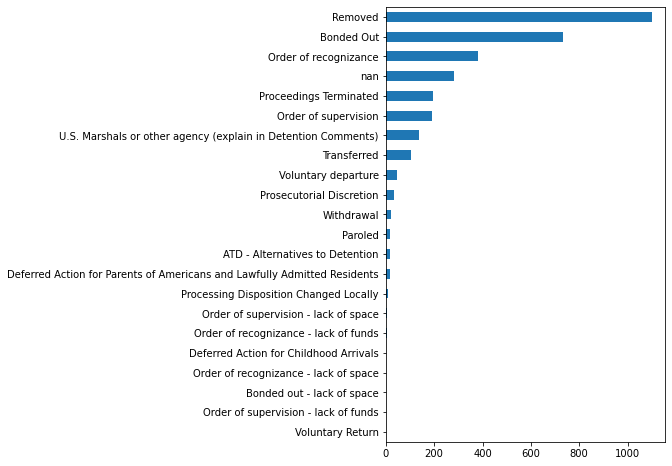

<IPython.core.display.Javascript object>

In [95]:
never_transferred.history_release_reason.value_counts(dropna=False).sort_values().plot(
    kind="barh", figsize=(5, 8)
)

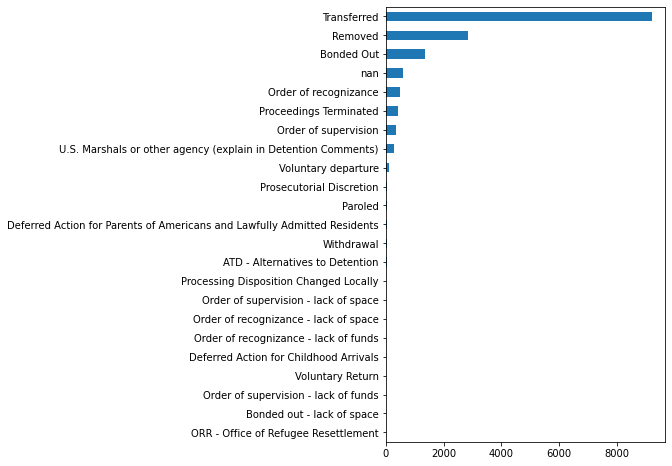

<IPython.core.display.Javascript object>

In [96]:
nyc_data.history_release_reason.value_counts(dropna=False).sort_values().plot(
    kind="barh", figsize=(5, 8)
)